In [5]:
import mlrose_ky as mlrose
import torch
import pyperch
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Problem

In [48]:
N = 100
T = 10
seed = 42
fitness = mlrose.FourPeaks(t_pct=T/N)
problem = mlrose.DiscreteOpt(length=N, fitness_fn=fitness, maximize=True, max_val=2)

# Hyperparameter Tuning

In [110]:
def hyperparameter_plot(df, parameter): 
    fig, ax1 = plt.subplots(figsize=(10, 5))

    plt.style.use("classic")
    fig.patch.set_facecolor("white")
    ax1.set_xlabel(parameter)
    ax1.set_ylabel("Fitness", color='b')
    ax1.plot(df[parameter], df["Fitness"], label="Fitness", marker='o', color='blue', linewidth=2, markersize=6)
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=10)
    ax1.tick_params(axis='x', labelsize=10)
    ax1.grid(True, linestyle="--", alpha=0.6)
    # ax1.set_xlim([-2, max(df[parameter]) + 3])
    ax1.set_ylim([0, max(df["Fitness"]) + 2])

    ax2 = ax1.twinx()
    ax2.set_ylabel("FEvals", color='r')
    ax2.plot(df[parameter], df["FEvals"], label="FEvals", marker='s', linestyle='dashed', color='red', linewidth=2, markersize=6)
    ax2.tick_params(axis='y', labelcolor='red', labelsize=10)
    ax2.set_ylim([0, max(df["FEvals"]) + 500])

    plt.title(f"Relationship Between {parameter}, Fitness, and FEvals")
    fig.tight_layout()
    plt.grid()
    plt.show()

# RHC

In [158]:
max_attempts=30
iteration_list=[500]
restart_list = [50]

rhc = mlrose.RHCRunner(problem=problem,
                        experiment_name="RHC",
                        seed=seed,
                        iteration_list = iteration_list,
                        max_attempts=max_attempts,
                        restart_list=restart_list
                        )

rhc_run_stats, rhc_run_curves = rhc.run()

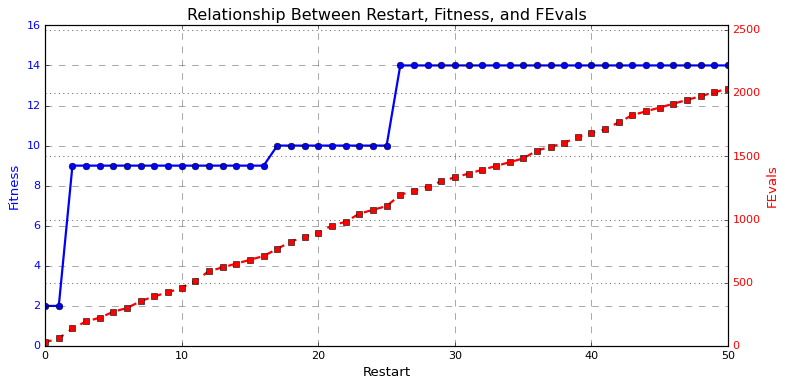

In [159]:
df_restart = []

for restart in sorted(rhc_run_curves["current_restart"].unique()):
    df_filtered = rhc_run_curves[rhc_run_curves["current_restart"] <= restart]
    
    total_time = df_filtered["Time"].sum()
    max_fitness = df_filtered["Fitness"].max()
    max_fevals = df_filtered["FEvals"].max()
    
    df_restart.append({"Restart": restart, "Total_Time": total_time, 
                       "Fitness": max_fitness, "FEvals": max_fevals})
    
df_restart = pd.DataFrame(df_restart)
hyperparameter_plot(df_restart, "Restart")


# SA

In [163]:
sa_runner_decay = mlrose.SARunner(
    problem=problem,
    experiment_name="SA",
    seed=seed,
    iteration_list=[500],
    temperature_list=[1],
    decay_list=[mlrose.GeomDecay, mlrose.ArithDecay, mlrose.ExpDecay],
    max_attempts=30
)

sa_runner_temp = mlrose.SARunner(
    problem=problem,
    experiment_name="SA",
    seed=seed,
    iteration_list=[500],
    temperature_list=[0.1, 1, 10, 50, 100],
    decay_list=[mlrose.GeomDecay],
    max_attempts=30
)

sa_run_stats_d, sa_run_curves_d = sa_runner_decay.run()
sa_run_stats_t, sa_run_curves_t = sa_runner_temp.run()

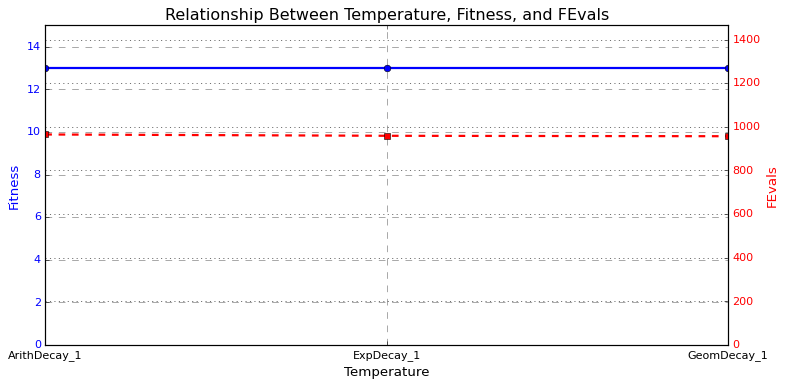

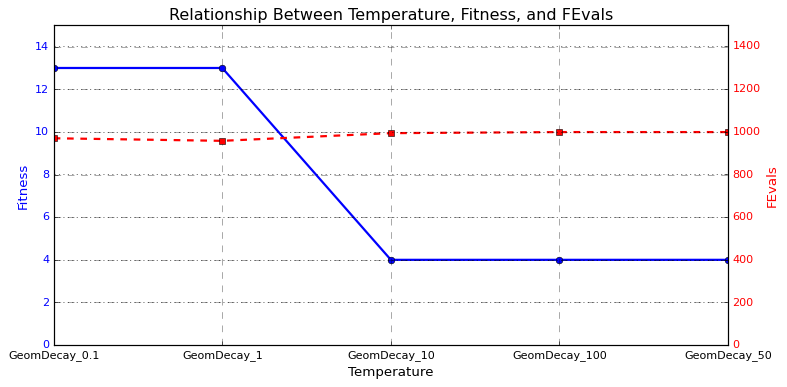

In [ ]:
def format_temperature(temp):
    if isinstance(temp, object):
        temp = str(temp)
        if "ArithDecay" in temp:
            return f"ArithDecay_{temp.split('=')[1].split(',')[0]}"
        elif "ExpDecay" in temp:
            return f"ExpDecay_{temp.split('=')[1].split(',')[0]}"
        else:
            return f"GeomDecay_{temp}"
    else:
        return f"Temp_{temp}"

sa_run_curves_d["Temperature"] = sa_run_curves_d["Temperature"].apply(format_temperature)
sa_run_curves_t["Temperature"] = sa_run_curves_t["Temperature"].apply(format_temperature)


decay = sa_run_curves_d.groupby("Temperature").agg({"Time":"sum", "Fitness":"max", "FEvals":"max"}).reset_index()
hyperparameter_plot(decay, "Temperature")

temp = sa_run_curves_t.groupby("Temperature").agg({"Time":"sum", "Fitness":"max", "FEvals":"max"}).reset_index()
hyperparameter_plot(temp, "Temperature")

# GA

In [156]:
ga_runner_population = mlrose.GARunner(
    problem=problem,
    experiment_name="GA",
    seed=seed,
    iteration_list=[500], 
    max_attempts=30,
    population_sizes=[20, 50, 100, 200],
    mutation_rates=[0.5]
)

ga_runner_mutation = mlrose.GARunner(
    problem=problem,
    experiment_name="GA",
    seed=seed,
    iteration_list=[500], 
    max_attempts=30,
    population_sizes=[200],
    mutation_rates=[0.01, 0.1, 0.2, 0.5]
)

ga_run_stats_p, ga_run_curves_p = ga_runner_population.run()
ga_run_stats_m, ga_run_curves_m = ga_runner_mutation.run()

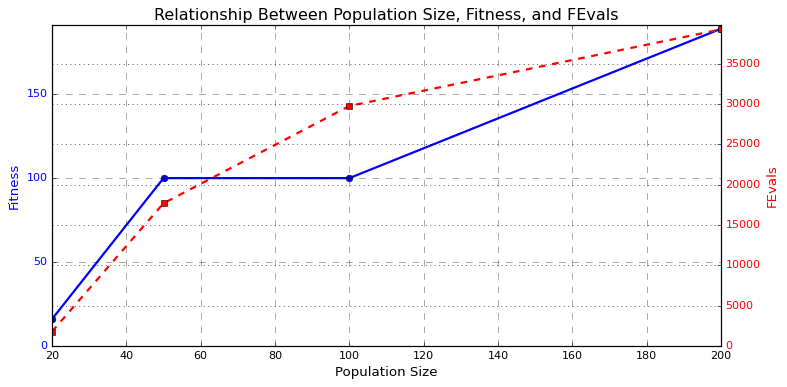

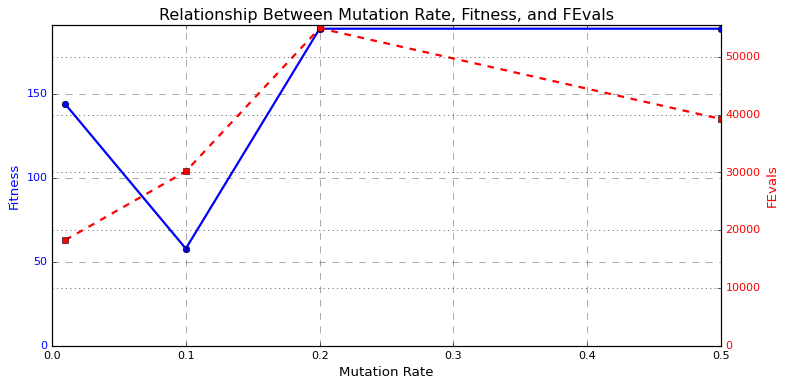

In [157]:
population_size = ga_run_curves_p.groupby("Population Size").agg({"Time":"sum", "Fitness":"max", "FEvals":"max"}).reset_index()
hyperparameter_plot(population_size, "Population Size")

mutation_rate = ga_run_curves_m.groupby("Mutation Rate").agg({"Time":"sum", "Fitness":"max", "FEvals":"max"}).reset_index()
hyperparameter_plot(mutation_rate, "Mutation Rate")

# Model Comparison

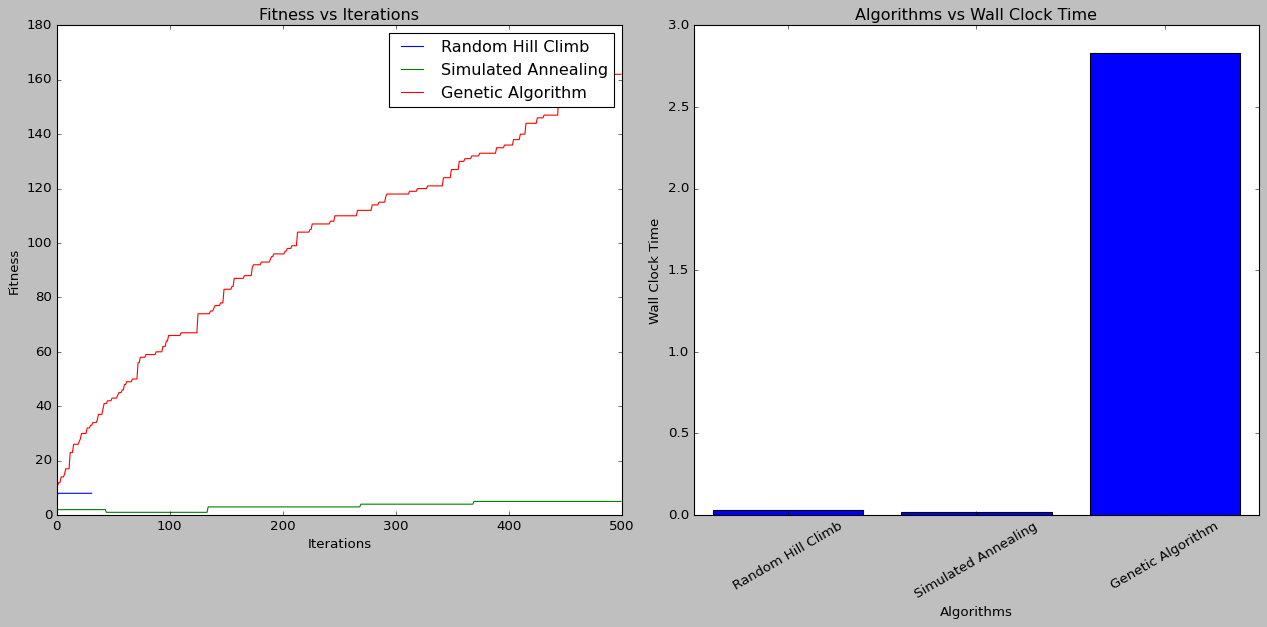

In [177]:

algorithms = {
    "Random Hill Climb": lambda: mlrose.random_hill_climb(problem, max_attempts=30, restarts=30, random_state=seed, max_iters=500, curve=True),
    "Simulated Annealing": lambda: mlrose.simulated_annealing(problem, schedule=mlrose.GeomDecay(), random_state=seed, max_attempts=30, max_iters=500, curve=True),
    "Genetic Algorithm": lambda: mlrose.genetic_alg(problem, pop_size=200, mutation_prob=0.5, random_state=seed, max_attempts=30, max_iters=500, curve=True)
}

results = {}

for name, algo in algorithms.items():
    start_time = time.time()
    best_state, best_fitness, fitness_curve = algo()
    end_time = time.time()
    
    results[name] = {
        "fitness_curve": fitness_curve[:, 0],
        "function_evals": len(fitness_curve),
        "wall_clock_time": end_time - start_time,
        "final_fitness": best_fitness
    }

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
for name, data in results.items():
    plt.plot(data["fitness_curve"], label=name)
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.title("Fitness vs Iterations")
plt.legend()

plt.subplot(1, 2, 2)
bar_positions = np.arange(len(results))
bar_heights = [data["wall_clock_time"] for data in results.values()]
plt.bar(bar_positions, bar_heights, tick_label=list(results.keys()))
plt.xlabel("Algorithms")
plt.ylabel("Wall Clock Time")
plt.title("Algorithms vs Wall Clock Time")
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()


# Varying Problem Size

In [169]:
problem_sizes = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

results = {}

for size in problem_sizes:
    fitness = mlrose.FourPeaks(t_pct=0.1) 
    problem = mlrose.DiscreteOpt(length=size, fitness_fn=fitness, maximize=True, max_val=2)
    
    algorithms = {
        "Random Hill Climb": lambda: mlrose.random_hill_climb(problem, max_attempts=30, restarts=30, random_state=seed, max_iters=500, curve=True),
        "Simulated Annealing": lambda: mlrose.simulated_annealing(problem, schedule=mlrose.GeomDecay(), random_state=seed, max_attempts=30, max_iters=500, curve=True),
        "Genetic Algorithm": lambda: mlrose.genetic_alg(problem, pop_size=200, mutation_prob=0.5, random_state=seed, max_attempts=30, max_iters=500, curve=True)
    }
    
    results[size] = {}
    
    for name, algo in algorithms.items():
        start_time = time.time()
        best_state, best_fitness, fitness_curve = algo()
        end_time = time.time()
        
        results[size][name] = {
            "function_evals": len(fitness_curve),
            "wall_clock_time": end_time - start_time,
            "final_fitness": best_fitness
        }


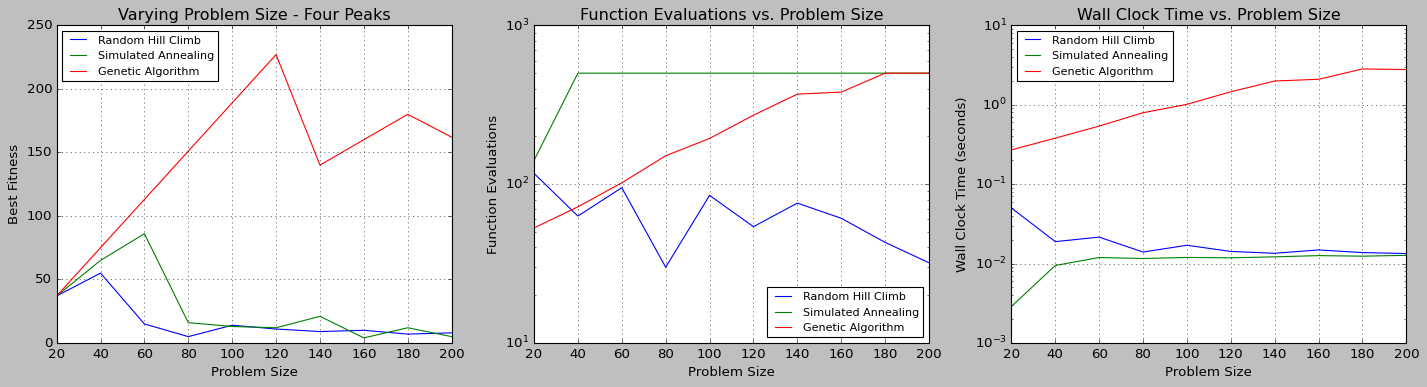

In [ ]:

problem_sizes_sorted = sorted(results.keys())
algo_names = ["Random Hill Climb", "Simulated Annealing", "Genetic Algorithm"]

fitness_results = {algo: [results[size][algo]["final_fitness"] for size in problem_sizes_sorted] for algo in algo_names}
fevals_results = {algo: [results[size][algo]["function_evals"] for size in problem_sizes_sorted] for algo in algo_names}
time_results = {algo: [results[size][algo]["wall_clock_time"] for size in problem_sizes_sorted] for algo in algo_names}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for algo in algo_names:
    axes[0].plot(problem_sizes_sorted, fitness_results[algo], label=algo)
axes[0].set_xlabel("Problem Size")
axes[0].set_ylabel("Best Fitness")
axes[0].set_title("Varying Problem Size - Four Peaks")
axes[0].legend(loc="upper left", fontsize=10)
axes[0].grid()

for algo in algo_names:
    axes[1].plot(problem_sizes_sorted, fevals_results[algo], label=algo)
axes[1].set_xlabel("Problem Size")
axes[1].set_ylabel("Function Evaluations")
axes[1].set_yscale("log")
axes[1].set_title("Function Evaluations vs. Problem Size")
axes[1].legend(loc="lower right", fontsize=10)
axes[1].grid()

for algo in algo_names:
    axes[2].plot(problem_sizes_sorted, time_results[algo], label=algo)
axes[2].set_xlabel("Problem Size")
axes[2].set_ylabel("Wall Clock Time (seconds)")
axes[2].set_yscale("log")
axes[2].set_title("Wall Clock Time vs. Problem Size")
axes[2].legend(loc="upper left", fontsize=10)
axes[2].grid()

plt.tight_layout()
plt.show()


1. Understand population_sizes in GA
2. NN weight tuning